# NBA Shot Success Prediction Using Machine Learning

## Data Loading and Initial Exploration

In [29]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime

from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from xgboost import XGBClassifier

In [30]:
file_name = 'shot_logs.csv'
df_loaded = pd.read_csv(file_name)

df_loaded.shape

(128069, 21)

In [31]:
df_loaded.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


Let's look at the columns.

In [32]:
df_loaded.columns

Index(['GAME_ID', 'MATCHUP', 'LOCATION', 'W', 'FINAL_MARGIN', 'SHOT_NUMBER',
       'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME',
       'SHOT_DIST', 'PTS_TYPE', 'SHOT_RESULT', 'CLOSEST_DEFENDER',
       'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST', 'FGM', 'PTS',
       'player_name', 'player_id'],
      dtype='object')

In [33]:
df_loaded.iloc[0][:]

GAME_ID                                       21400899
MATCHUP                       MAR 04, 2015 - CHA @ BKN
LOCATION                                             A
W                                                    W
FINAL_MARGIN                                        24
SHOT_NUMBER                                          1
PERIOD                                               1
GAME_CLOCK                                        1:09
SHOT_CLOCK                                        10.8
DRIBBLES                                             2
TOUCH_TIME                                         1.9
SHOT_DIST                                          7.7
PTS_TYPE                                             2
SHOT_RESULT                                       made
CLOSEST_DEFENDER                        Anderson, Alan
CLOSEST_DEFENDER_PLAYER_ID                      101187
CLOSE_DEF_DIST                                     1.3
FGM                                                  1
PTS       

In [34]:
# Number of unique values
df_loaded.nunique().sort_values(ascending=False)

MATCHUP                       1808
GAME_ID                        904
GAME_CLOCK                     719
CLOSEST_DEFENDER_PLAYER_ID     474
CLOSEST_DEFENDER               473
SHOT_DIST                      448
TOUCH_TIME                     313
CLOSE_DEF_DIST                 299
player_name                    281
player_id                      281
SHOT_CLOCK                     241
FINAL_MARGIN                    88
SHOT_NUMBER                     38
DRIBBLES                        33
PERIOD                           7
PTS                              3
PTS_TYPE                         2
SHOT_RESULT                      2
W                                2
LOCATION                         2
FGM                              2
dtype: int64

In [35]:
# Non-numerical columns
non_numerical_cols = df_loaded.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

print("Non-numerical columns:", non_numerical_cols)

Non-numerical columns: ['MATCHUP', 'LOCATION', 'W', 'GAME_CLOCK', 'SHOT_RESULT', 'CLOSEST_DEFENDER', 'player_name']


In [36]:
# Missing values
df_loaded.isnull().sum()[df_loaded.isnull().sum()>0]

SHOT_CLOCK    5567
dtype: int64

In [37]:
# Categorical columns
categorical_cols = df_loaded.select_dtypes(include=['object', 'category']).columns

print("Categorical columns:")
print(list(categorical_cols))

Categorical columns:
['MATCHUP', 'LOCATION', 'W', 'GAME_CLOCK', 'SHOT_RESULT', 'CLOSEST_DEFENDER', 'player_name']


## Data preparation

In [38]:
df = df_loaded.copy()
df.columns

Index(['GAME_ID', 'MATCHUP', 'LOCATION', 'W', 'FINAL_MARGIN', 'SHOT_NUMBER',
       'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME',
       'SHOT_DIST', 'PTS_TYPE', 'SHOT_RESULT', 'CLOSEST_DEFENDER',
       'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST', 'FGM', 'PTS',
       'player_name', 'player_id'],
      dtype='object')

I'll put SHOT_RESULT (target variable) as the last column.

In [39]:
cols = df.columns.tolist()

cols.remove('SHOT_RESULT')
cols.append('SHOT_RESULT')

df = df[cols]

### Useless features
I will first remove the features that don't bring any value by using my domain knowledge. Since 'player_name' and 'CLOSEST_DEFENDER' are giving the same information as 'player_id' and 'CLOSEST_DEFENDER_PLAYER_ID' I can remove them.

In [40]:
df = df.drop(columns=['player_name', 'CLOSEST_DEFENDER'])

Let's look at the correlation matrix of all numerical features.

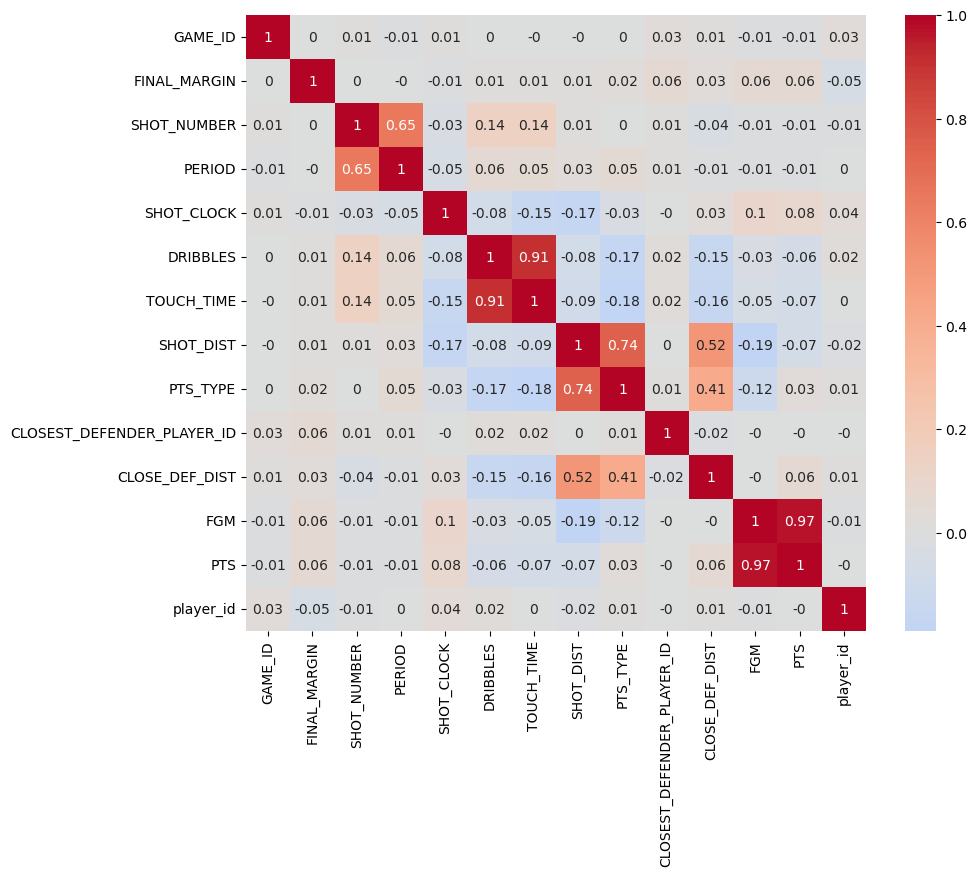

In [41]:
numeric_corr = df.select_dtypes(include=['int64', 'float64']).corr().round(2)

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_corr, annot=True, cmap='coolwarm', center=0)
plt.show()

As we can see 'SHOT_RESULTS' is really highly correlated with 'FGM' and 'PTS' so I will remove those 2.

In [42]:
df = df.drop(columns=['FGM', 'PTS'])

In [43]:
df.iloc[0]

GAME_ID                                       21400899
MATCHUP                       MAR 04, 2015 - CHA @ BKN
LOCATION                                             A
W                                                    W
FINAL_MARGIN                                        24
SHOT_NUMBER                                          1
PERIOD                                               1
GAME_CLOCK                                        1:09
SHOT_CLOCK                                        10.8
DRIBBLES                                             2
TOUCH_TIME                                         1.9
SHOT_DIST                                          7.7
PTS_TYPE                                             2
CLOSEST_DEFENDER_PLAYER_ID                      101187
CLOSE_DEF_DIST                                     1.3
player_id                                       203148
SHOT_RESULT                                       made
Name: 0, dtype: object

### Data leakage

I will remove post-prediction columns 'W' and 'FINAL_MARGIN' to prevent data leakage.

In [44]:
df = df.drop(columns=['W', 'FINAL_MARGIN'])

### Impossible cases

I will remove impossible cases (incorrect data) and put NaN instead (impute later).

In [45]:
# Replace invalid values with NaN for specific columns
df.loc[df['TOUCH_TIME'] <= 0, 'TOUCH_TIME'] = np.nan
df.loc[df['SHOT_DIST'] <= 0, 'SHOT_DIST'] = np.nan
df.loc[df['CLOSE_DEF_DIST'] <= 0, 'CLOSE_DEF_DIST'] = np.nan
df.loc[(df['SHOT_CLOCK'] < 0) | (df['SHOT_CLOCK'] > 24), 'SHOT_CLOCK'] = np.nan

### Categorical features

I will change categorical features into numerical: 

'SHOT_RESULT' -> 'made': 1, 'missed': 0

'LOCATION' -> 'A': 0, 'H': 1

'PTS_TYPE' is categorical but doesn't require change into 0 and 1 because the values are already numerical and the actual numbers (2 and 3) have meaningful mathematical relationships that reflect the real scoring system.

In [46]:
df['SHOT_RESULT'] = df['SHOT_RESULT'].map({'made': 1, 'missed': 0})
df['LOCATION'] = df['LOCATION'].map({'A': 0, 'H': 1})

I will transform 'PERIOD' with one-hot encoding because I think periods are not ordinal feature. This means that players's shooting doesn't increase or decrease through periods but can be bad in period 1, then good in periods 2 and 3, then again bad in period 4...

In [47]:
period_dummies = pd.get_dummies(df['PERIOD'], prefix='PERIOD', drop_first=True, dtype=int)
df = df.drop(columns=['PERIOD'])
df = pd.concat([df, period_dummies], axis=1)

### Feature engineering

I will create or change some existing features in this part:

'GAME_CLOCK' into seconds

In [48]:
def convert_to_seconds(time_str):
    if pd.isna(time_str):
        return None
    minutes, seconds = map(int, time_str.split(':'))
    return minutes * 60 + seconds

In [49]:
df['GAME_CLOCK'] = df['GAME_CLOCK'].apply(convert_to_seconds)

'MATCHUP' into 'DAY_OF_SEASON', 'PLAYER_TEAM' and 'DEFENDER TEAM'

In [50]:
# Split MATCHUP into date and teams parts
df[['date_str', 'teams']] = df['MATCHUP'].str.split(' - ', expand=True)

# Convert dates
dates = pd.to_datetime(df['date_str'], format='%b %d, %Y')

# Calculate days since season start
days_since_start = (dates - dates.min()).dt.days

# Split teams (they're all in format "TEAM1 @ TEAM2" or "TEAM1 vs. TEAM2")
df[['team1', 'team2']] = df['teams'].str.extract(r'(\w+) [@vs.] (\w+)')

# Assign teams based on LOCATION
player_team = np.where(df['LOCATION'] == 1, df['team2'], df['team1'])
defender_team = np.where(df['LOCATION'] == 1, df['team1'], df['team2'])

# Add new features to df
df['DAY_OF_SEASON'] = days_since_start
df['PLAYER_TEAM'] = player_team
df['DEFENDER_TEAM'] = defender_team

df = df.drop(columns=['MATCHUP', 'date_str', 'teams', 'team1', 'team2'])

In [51]:
# Create one-hot encoding for PLAYER_TEAM
player_team_dummies = pd.get_dummies(df['PLAYER_TEAM'], prefix='PLAYER_TEAM', drop_first=True)

# Create one-hot encoding for DEFENDER_TEAM
defender_team_dummies = pd.get_dummies(df['DEFENDER_TEAM'], prefix='DEFENDER_TEAM', drop_first=True)

# Concatenate the original dataframe with the new dummy variables
df = pd.concat([df, player_team_dummies, defender_team_dummies], axis=1)

df = df.drop(columns=['PLAYER_TEAM', 'DEFENDER_TEAM'])

In [52]:
df.iloc[0]

GAME_ID              21400899.0
LOCATION                    0.0
SHOT_NUMBER                 1.0
GAME_CLOCK                 69.0
SHOT_CLOCK                 10.8
                        ...    
DEFENDER_TEAM_SAC           0.0
DEFENDER_TEAM_SAS           0.0
DEFENDER_TEAM_TOR           0.0
DEFENDER_TEAM_UTA           0.0
DEFENDER_TEAM_WAS           0.0
Name: 0, Length: 78, dtype: float64

I will create a feature 'PLAYER_SHOOTING_AVG' which is shooting percentage until that shot and 'DEFENDER_SUCCESS_RATE' which is percentage of succesful defenses.

'LAST_3_SHOTS_PCT' is a feature of the last 3 shots taken by the player.

In [53]:
df = df.sort_values(['GAME_ID', 'SHOT_NUMBER'])

df['PLAYER_HIST_SHOOTING_AVG'] = df.groupby('player_id')['SHOT_RESULT'].transform(
    lambda x: x.shift().expanding().mean()
)

df['DEFENDER_HIST_SUCCESS_RATE'] = df.groupby('CLOSEST_DEFENDER_PLAYER_ID')['SHOT_RESULT'].transform(
    lambda x: x.shift().expanding().mean()
)

def last_n_shots_no_leakage(group, n=3):
    return group['SHOT_RESULT'].shift().rolling(window=n, min_periods=1).mean()

df['LAST_3_SHOTS_PCT'] = df.groupby(['GAME_ID', 'player_id']).apply(last_n_shots_no_leakage).reset_index(level=[0,1], drop=True)

In [54]:
global_mean = df['SHOT_RESULT'].mean()

columns_to_fill = ['PLAYER_HIST_SHOOTING_AVG', 'DEFENDER_HIST_SUCCESS_RATE', 'LAST_3_SHOTS_PCT']

for column in columns_to_fill:
    df[column] = df[column].fillna(global_mean)

### Missing values

In [55]:
df.isnull().sum()[df.isnull().sum()>0]

SHOT_CLOCK        5567
TOUCH_TIME        3358
SHOT_DIST            4
CLOSE_DEF_DIST    1056
dtype: int64

In [56]:
df_copy = df.copy()

# Get a 10% random sample for training the imputer
df_sample, _ = train_test_split(df, train_size=0.1, random_state=42)

# Initialize the imputer
imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=100, random_state=42),
    random_state=42,
    max_iter=10
)

# Fit the imputer on the sample
imputer.fit(df_sample)

# Transform the entire dataset
imputed_values = imputer.transform(df_copy)

# Convert back to dataframe with original column names
df_imputed = pd.DataFrame(imputed_values, columns=df.columns, index=df.index)

# Replace the original dataframe
df = df_imputed.copy()

## Feature importance

In [57]:
target = 'SHOT_RESULT'
df.columns

Index(['GAME_ID', 'LOCATION', 'SHOT_NUMBER', 'GAME_CLOCK', 'SHOT_CLOCK',
       'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST', 'PTS_TYPE',
       'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST', 'player_id',
       'SHOT_RESULT', 'PERIOD_2', 'PERIOD_3', 'PERIOD_4', 'PERIOD_5',
       'PERIOD_6', 'PERIOD_7', 'DAY_OF_SEASON', 'PLAYER_TEAM_BKN',
       'PLAYER_TEAM_BOS', 'PLAYER_TEAM_CHA', 'PLAYER_TEAM_CHI',
       'PLAYER_TEAM_CLE', 'PLAYER_TEAM_DAL', 'PLAYER_TEAM_DEN',
       'PLAYER_TEAM_DET', 'PLAYER_TEAM_GSW', 'PLAYER_TEAM_HOU',
       'PLAYER_TEAM_IND', 'PLAYER_TEAM_LAC', 'PLAYER_TEAM_LAL',
       'PLAYER_TEAM_MEM', 'PLAYER_TEAM_MIA', 'PLAYER_TEAM_MIL',
       'PLAYER_TEAM_MIN', 'PLAYER_TEAM_NOP', 'PLAYER_TEAM_NYK',
       'PLAYER_TEAM_OKC', 'PLAYER_TEAM_ORL', 'PLAYER_TEAM_PHI',
       'PLAYER_TEAM_PHX', 'PLAYER_TEAM_POR', 'PLAYER_TEAM_SAC',
       'PLAYER_TEAM_SAS', 'PLAYER_TEAM_TOR', 'PLAYER_TEAM_UTA',
       'PLAYER_TEAM_WAS', 'DEFENDER_TEAM_BKN', 'DEFENDER_TEAM_BOS',
       'DEFENDER_TEA

### XGB feature importance

In [58]:
X = df.drop(columns=['SHOT_RESULT'])
y = df[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=48)

# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [59]:
# Initialize and train XGBoostClassifier
xgb_model = XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=4,
    random_state=41
)

xgb_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test_scaled)

# Print results
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6288

Classification Report:
              precision    recall  f1-score   support

         0.0       0.62      0.86      0.72      3556
         1.0       0.66      0.34      0.45      2848

    accuracy                           0.63      6404
   macro avg       0.64      0.60      0.58      6404
weighted avg       0.64      0.63      0.60      6404



In [60]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
})
print("\nTop 10 Feature Importance:")
print(feature_importance.sort_values('importance', ascending=False).head(10))


Top 10 Feature Importance:
            feature  importance
7         SHOT_DIST    0.237408
10   CLOSE_DEF_DIST    0.106065
6        TOUCH_TIME    0.050773
4        SHOT_CLOCK    0.035463
3        GAME_CLOCK    0.023440
36  PLAYER_TEAM_NOP    0.019835
8          PTS_TYPE    0.019666
5          DRIBBLES    0.017629
41  PLAYER_TEAM_PHX    0.017175
33  PLAYER_TEAM_MIA    0.016128


### Random forest feature importance

In [61]:
# Initialize and train RandomForestClassifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=4,
    random_state=13
)

rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Print results
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6237

Classification Report:
              precision    recall  f1-score   support

         0.0       0.61      0.88      0.72      3556
         1.0       0.67      0.30      0.42      2848

    accuracy                           0.62      6404
   macro avg       0.64      0.59      0.57      6404
weighted avg       0.64      0.62      0.59      6404



In [62]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})
print("\nTop 10 Feature Importance:")
print(feature_importance.sort_values('importance', ascending=False).head(10))


Top 10 Feature Importance:
                       feature  importance
7                    SHOT_DIST    0.380706
4                   SHOT_CLOCK    0.157980
8                     PTS_TYPE    0.149077
6                   TOUCH_TIME    0.094973
3                   GAME_CLOCK    0.060317
77    PLAYER_HIST_SHOOTING_AVG    0.044384
5                     DRIBBLES    0.034100
10              CLOSE_DEF_DIST    0.033099
11                   player_id    0.009877
78  DEFENDER_HIST_SUCCESS_RATE    0.007088


After using XGB and RF for feature importance, I can conclude that the most important features are:

SHOT_DIST, PTS_TYPE, SHOT_CLOCK, TOUCH_TIME, GAME_CLOCK, PLAYER_HIST_SHOOTING_AVG, DRIBBLES and CLOSE_DEF_DIST. 

In [63]:
important_features = feature_importance.sort_values('importance', ascending=False).head(8)['feature'].tolist()
important_features

['SHOT_DIST',
 'SHOT_CLOCK',
 'PTS_TYPE',
 'TOUCH_TIME',
 'GAME_CLOCK',
 'PLAYER_HIST_SHOOTING_AVG',
 'DRIBBLES',
 'CLOSE_DEF_DIST']

## Data visualization

Let's look at the histograms of all important features and their connection with shot accuracy.

In [64]:
def histogram_and_acc(df, feature, target):
    """
    Creates a histogram of feature variable and a plot showing accuracy per feature value
    
    Parameters:
    df (DataFrame): Input dataframe
    feature (str): Name of feature column
    target (str): Name of target column
    """
    
    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    
    # Plot histogram on first subplot
    ax1.hist(df[feature], bins=30, edgecolor='black')
    ax1.set_title(f'Histogram of {feature}')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('Count')
    
    # Round feature to 1 decimal place
    df = df.copy()
    df[f'{feature}_rounded'] = df[feature].round(1)
    
    # Calculate accuracy for each rounded value
    accuracy_per_value = (df.groupby(f'{feature}_rounded')[target]
                         .agg(['count', 'mean'])
                         .reset_index())
    
    # Rename columns for clarity
    accuracy_per_value.columns = ['feature_value', 'total_count', 'accuracy']
    
    # Convert accuracy to percentage
    accuracy_per_value['accuracy'] = accuracy_per_value['accuracy'] * 100
    
    # Create line plot on second subplot
    ax2.plot(accuracy_per_value['feature_value'], 
            accuracy_per_value['accuracy'],
            linewidth=2)
    
    ax2.set_title(f'Accuracy per {feature} value')
    ax2.set_xlabel(feature)
    ax2.set_ylabel('Accuracy (%)')
    
    # Add grid for better readability
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    return

SHOT_DIST


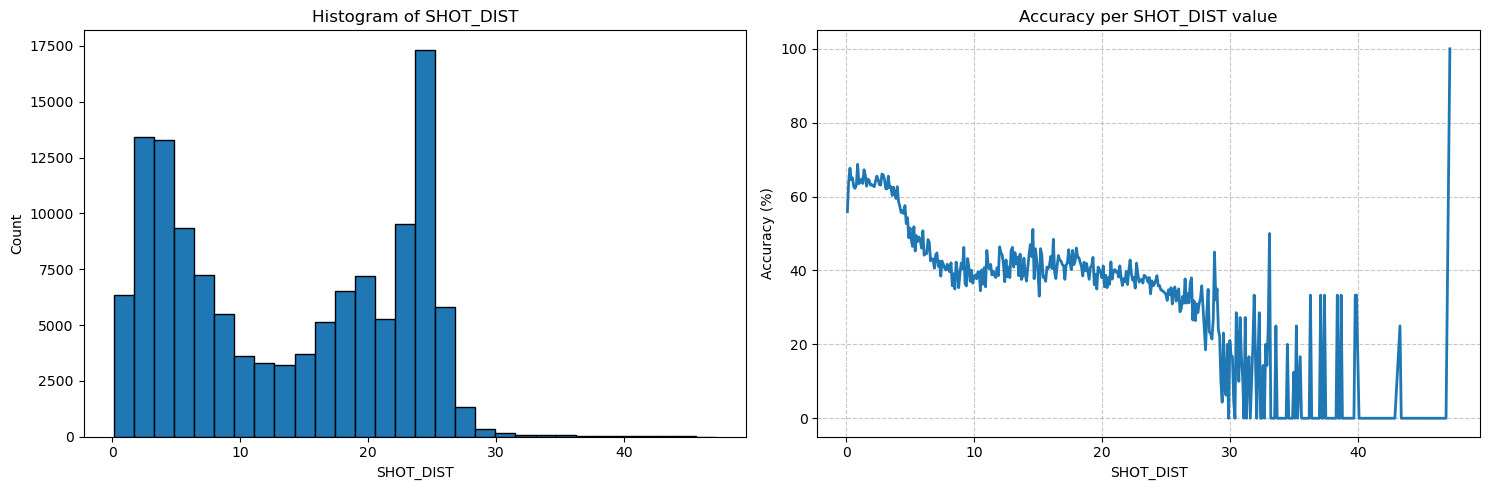

SHOT_CLOCK


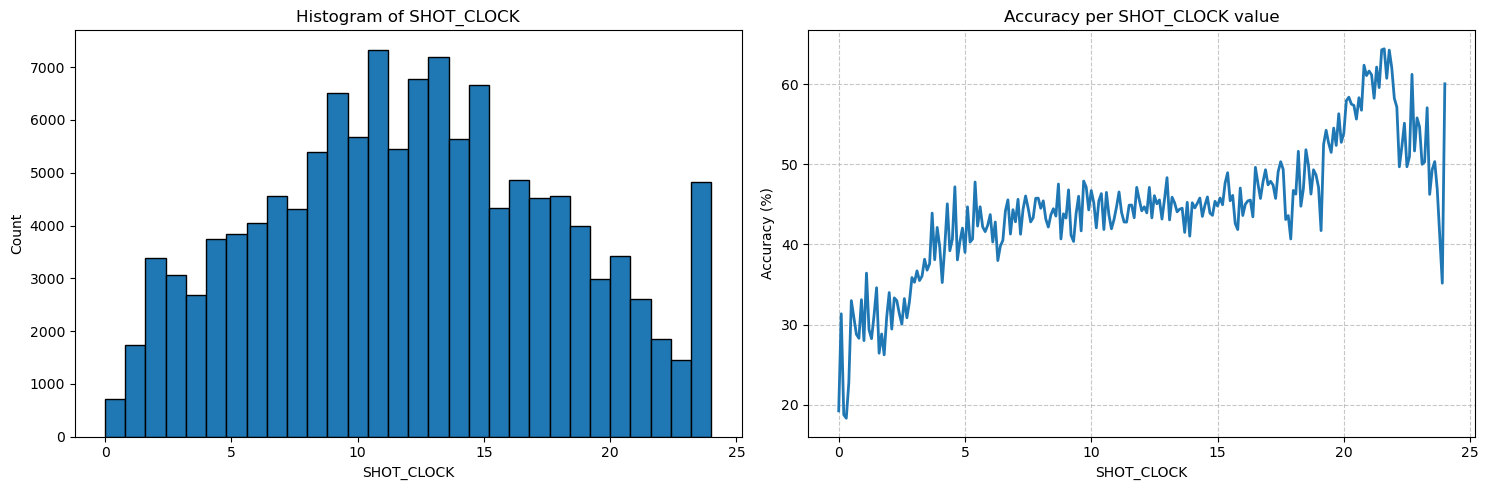

PTS_TYPE


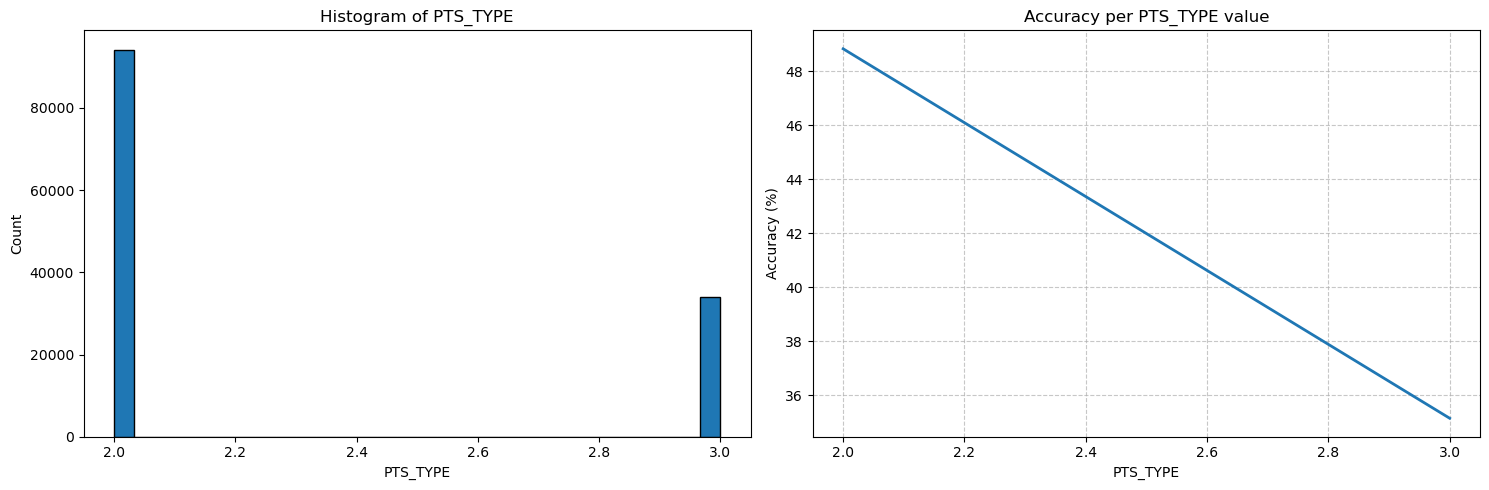

TOUCH_TIME


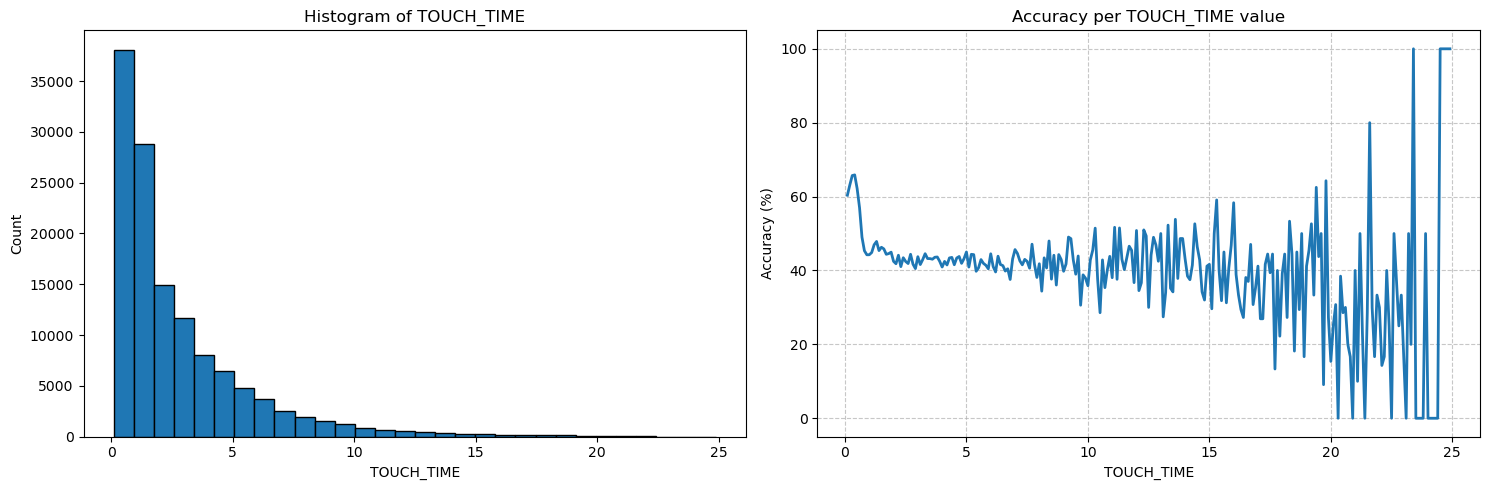

GAME_CLOCK


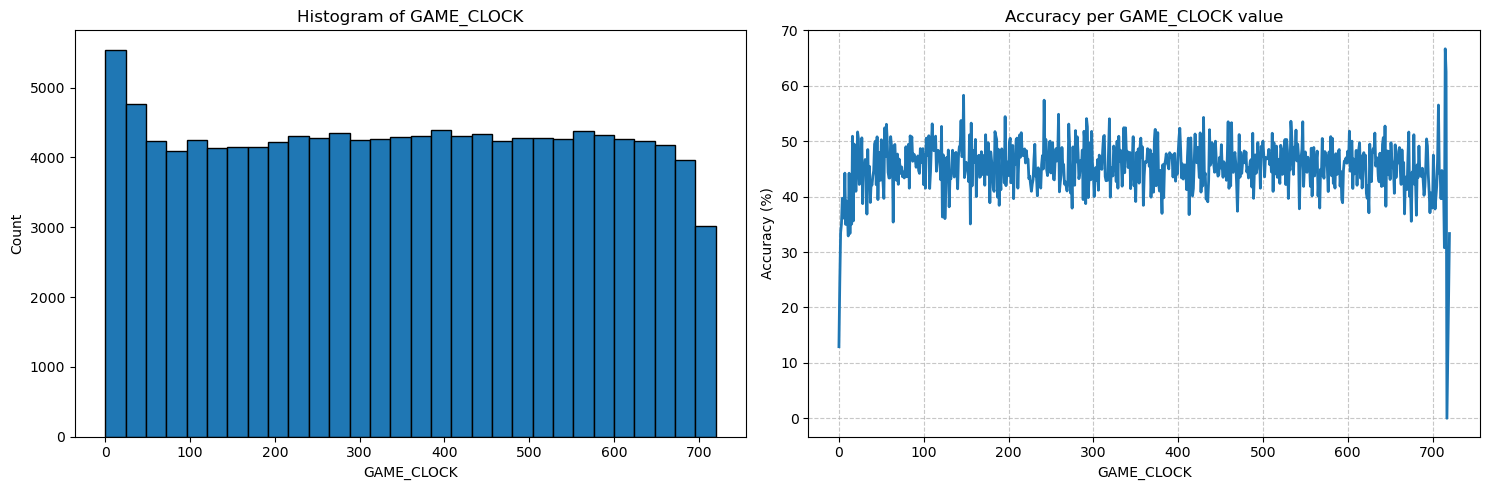

PLAYER_HIST_SHOOTING_AVG


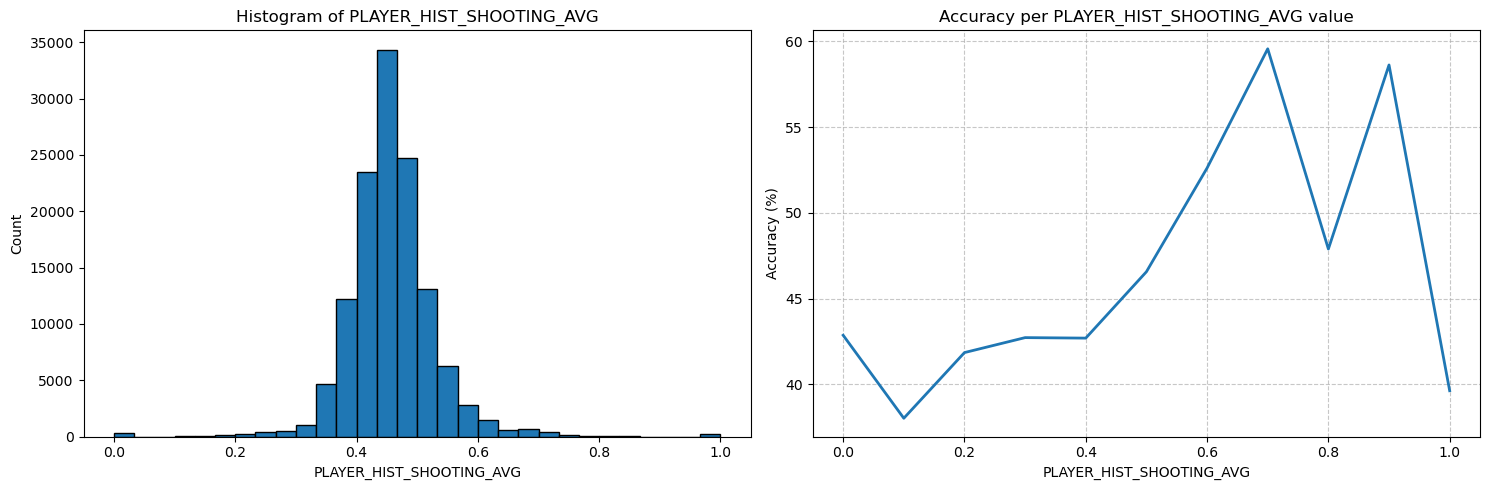

DRIBBLES


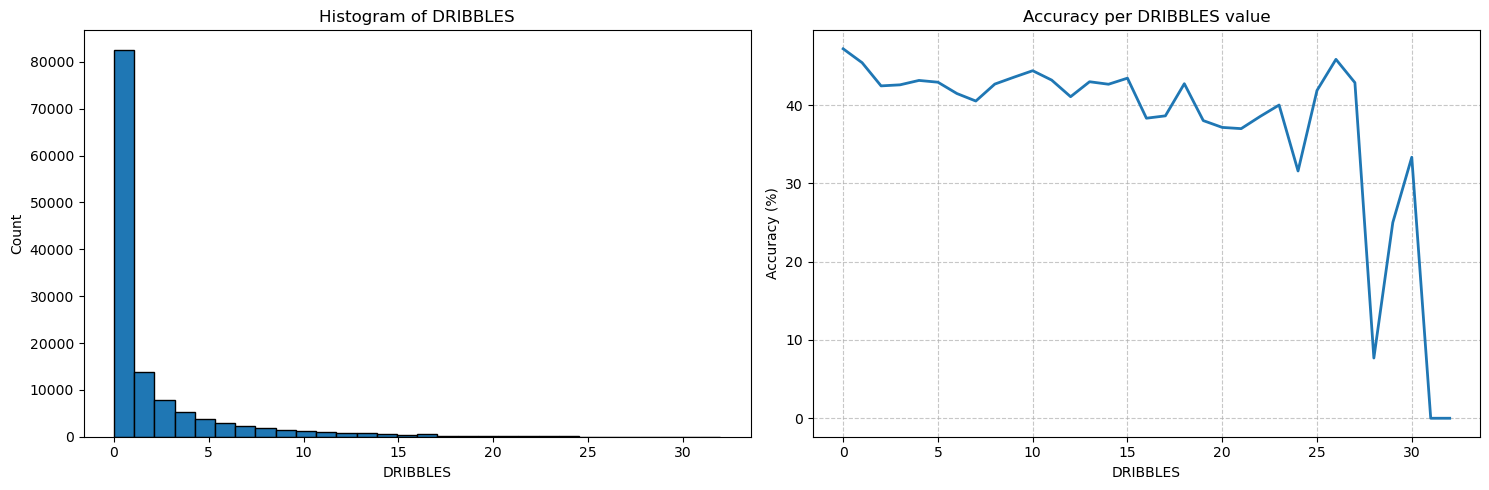

CLOSE_DEF_DIST


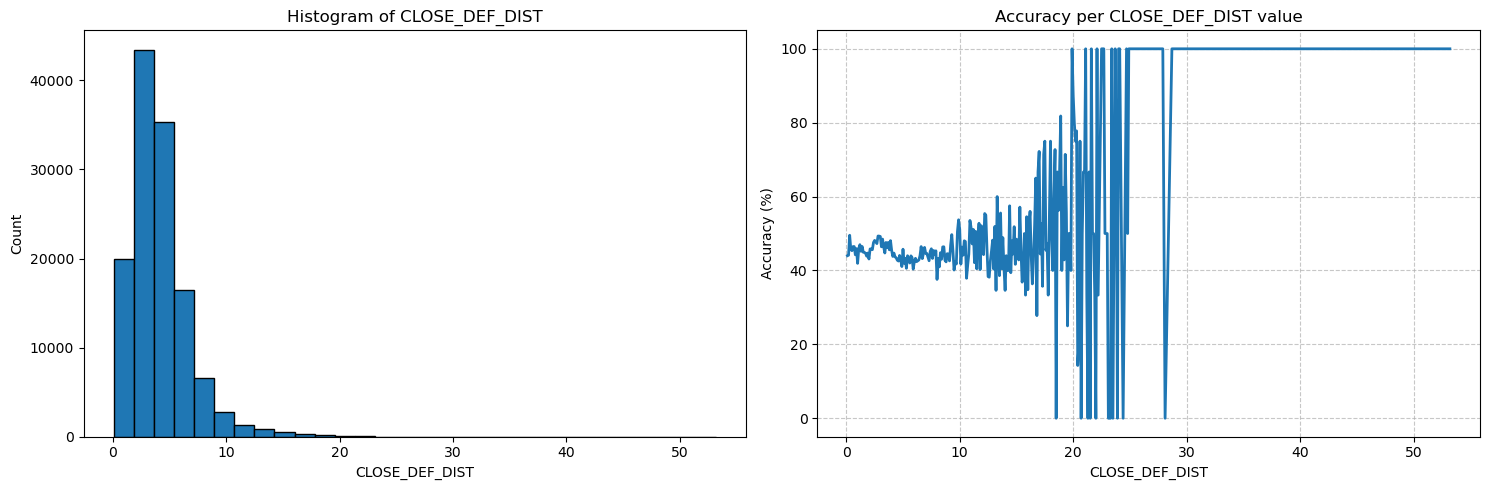

In [65]:
for feature in important_features:
    print(feature)
    histogram_and_acc(df, feature, target)

The plots show what we could expect such as:

higher accuracy of a shot if: SHOT_DIST low, PTS_TYPE is 2, SHOT_CLOCK high.

PTS_TYPE and accuracy plot doesn't make much sense for the values between 2 and 3 (because they don't exist).

Interesting thing is that accuracy is really high (>60%) when TOUCH_TIME is really low which is (I assume) due to the "catch and shoot" when players are left open or also which are usually taken by the players who's main role is shooting (therefore the higher accuracy).

In some plots we can see that accuracy starts to fluctuate. That's because it doesn't matter if eg CLOSE_DEF_DIST is 20 or 30 because a shooter is open anyway. Here I will set those high values to the value where the accuracy line starts to fluctuate.

For some other features (such as SHOT_DIST) I have a problem that there are some outliers (shots that are very rarely taken). I could remove them which would probably cause the accuracy to increase, but I don't think this approach is good for real-life use where these kinds of shots are still sometimes taken.

In [66]:
df['TOUCH_TIME'] = df['TOUCH_TIME'].clip(upper=15)
df['CLOSE_DEF_DIST'] = df['CLOSE_DEF_DIST'].clip(upper=18)

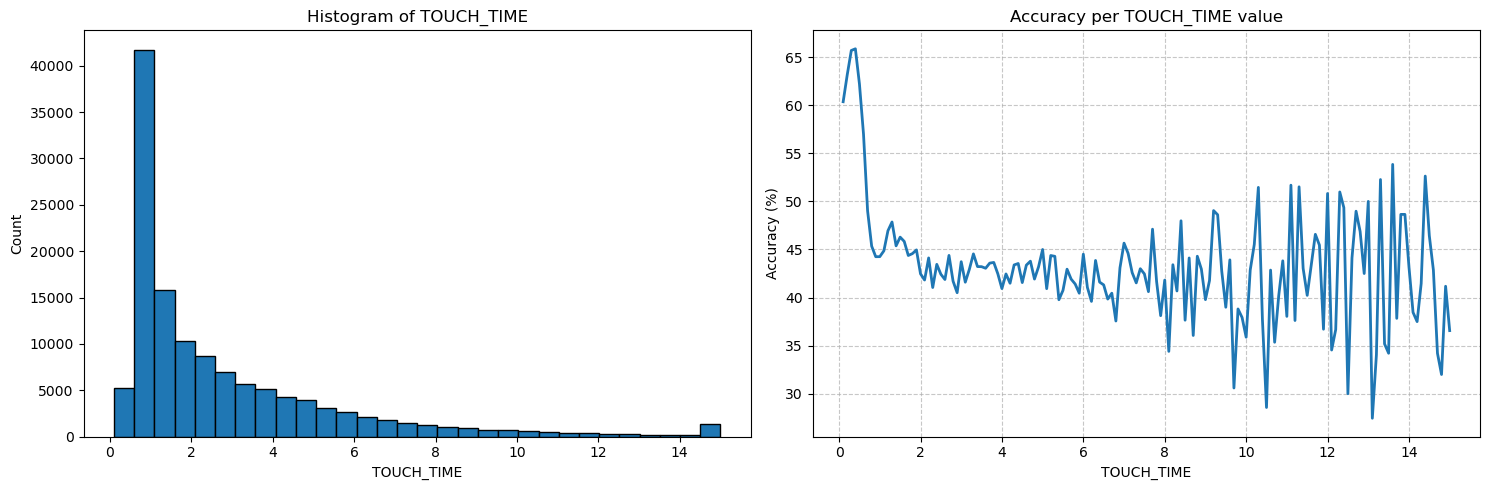

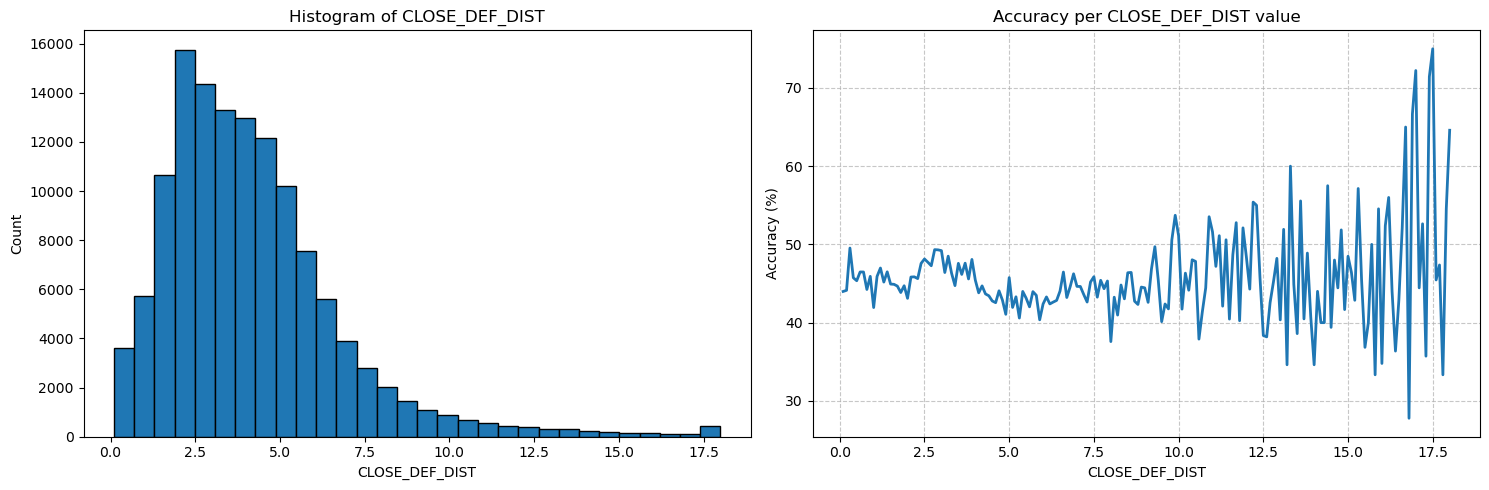

In [67]:
histogram_and_acc(df, 'TOUCH_TIME', target)
histogram_and_acc(df, 'CLOSE_DEF_DIST', target)